In [413]:
"""Transformation of quantitative data."""

'Transformation of quantitative data.'

# Преобразование количественных данных

In [ ]:
# pylint: disable=too-many-lines

import io
import os
import time

# напишем простой encoder
# будем передавать в функцию данные, столбец, который нужно кодировать,
# и схему кодирования (map)
import joblib
import matplotlib.pyplot as plt

# импортируем библиотеки
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from dotenv import load_dotenv
from joblib import Parallel, delayed

# fmt: off
from pandas import DataFrame

# создадим матрицу в формате сжатого хранения строкой
from scipy.sparse import csr_matrix

# рассчитаем предпоследнее значение с помощью библиотеки scipy
# построим графики нормальной вероятности
# импортируем необходимые функции
from scipy.stats import kurtosis, norm, probplot, skew
from sklearn.compose import ColumnTransformer

# импортируем данные о недвижимости в Калифорнии
from sklearn.datasets import fetch_california_housing

# создадим объекты преобразователей для количественных
from sklearn.impute import SimpleImputer

# создадим объект модели, которая будет использовать все признаки
# и создания модели линейной регрессии
from sklearn.linear_model import LinearRegression, LogisticRegression

# разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# ColumnTransformer позволяет применять разные преобразователи к разным столбцам
# импортируем класс Pipeline
# импортируем класс make_pipeline (упрощенный вариант класса Pipeline) из модуля pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# выполним ту же операцию с помощью класса Normalizer
# применим MaxAbsScaler
# импортируем класс MinMaxScaler
# импортируем класс для стандартизации данных
# из модуля preprocessing импортируем класс StandardScaler
# наконец скачаем функцию степенного преобразования power_transform()
from sklearn.preprocessing import (
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    OrdinalEncoder,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    power_transform,
)

# и категориального признака

In [415]:
# установим размер и стиль Seaborn для последующих графиков
sns.set(rc={"figure.figsize": (8, 5)})

### Подготовка данных

In [ ]:
load_dotenv()

boston_csv_url = os.environ.get("BOSTON_CSV_URL", "")
response = requests.get(boston_csv_url)

# возьмем признак LSTAT (процент населения с низким социальным статусом)
# и целевую переменную MEDV (медианная стоимость жилья)
boston = pd.read_csv(io.BytesIO(response.content))[["LSTAT", "MEDV"]]
boston.shape

(506, 2)

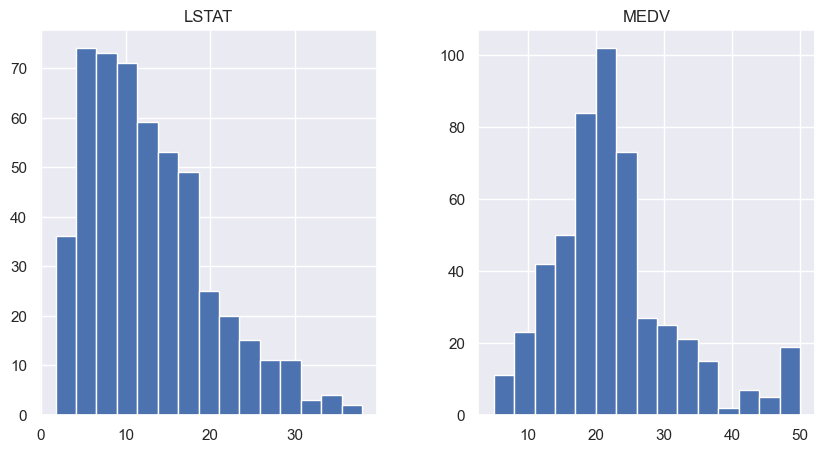

In [417]:
# посмотрим на данные с помощью гистограммы
boston.hist(bins=15, figsize=(10, 5));

In [418]:
# посмотрим на основные статистические показатели
boston.describe()

,LSTAT,MEDV
count,506.000000,506.000000
mean,12.653063,22.532806
std,7.141062,9.197104
min,1.730000,5.000000
25%,6.950000,17.025000
50%,11.360000,21.200000
75%,16.955000,25.000000
max,37.970000,50.000000


#### Пример преобразований

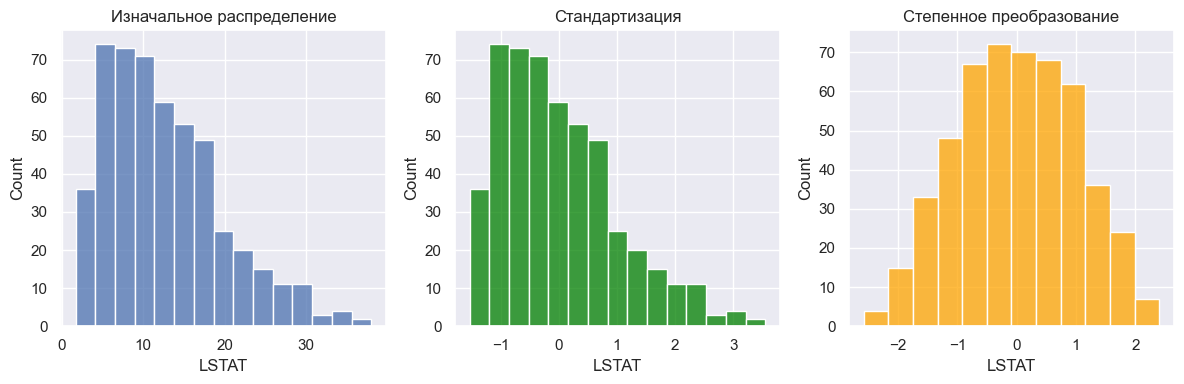

In [419]:
# создадим сетку подграфиков 1 x 3
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# на первом графике разместим изначальное распределение
sns.histplot(data=boston, x="LSTAT", bins=15, ax=ax[0])
ax[0].set_title("Изначальное распределение")

# на втором - данные после стандартизации
sns.histplot(
    x=(boston.LSTAT - np.mean(boston.LSTAT)) / np.std(boston.LSTAT),
    bins=15,
    color="green",
    ax=ax[1],
)
ax[1].set_title("Стандартизация")


# и на третьем графике покажем преобразование Бокса-Кокса
sns.histplot(
    x=power_transform(boston[["LSTAT"]], method="box-cox").flatten(),
    bins=12,
    color="orange",
    ax=ax[2],
)
ax[2].set(title="Степенное преобразование", xlabel="LSTAT")

plt.tight_layout()
plt.show()

#### Добавление выбросов

In [420]:
# создадим два отличающихся наблюдения
outliers = pd.DataFrame({"LSTAT": [45, 50], "MEDV": [70, 72]})

# добавим их в исходный датафрейм
boston_outlier = pd.concat([boston, outliers], ignore_index=True)

# посмотрим на размерность нового датафрейма
boston_outlier.shape

(508, 2)

In [421]:
# убедимся, что наблюдения добавились
boston_outlier.tail()

,LSTAT,MEDV
503,5.64,23.9
504,6.48,22.0
505,7.88,11.9
506,45.00,70.0
507,50.00,72.0


[Text(0.5, 1.0, 'С выбросами')]

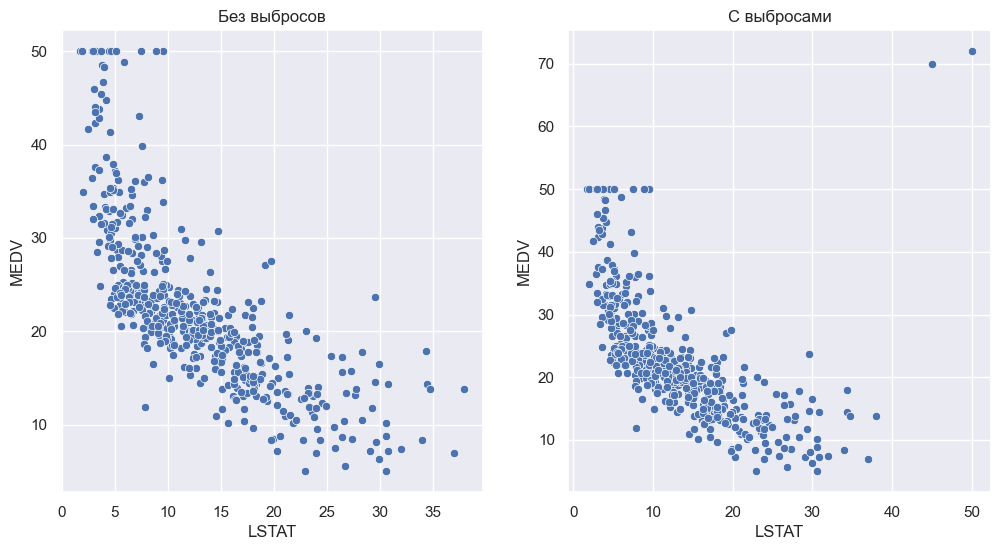

In [422]:
# fmt: off
# посмотрим на данные с выбросами и без
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(
    data=boston, x='LSTAT', y='MEDV', ax=ax[0]
).set(title='Без выбросов')

sns.scatterplot(
    data=boston_outlier, x='LSTAT', y='MEDV', ax=ax[1]
).set(title='С выбросами')
# fmt: on

## Линейные преобразования

### Стандартизация

#### Стандартизация вручную

In [423]:
((boston - boston.mean()) / boston.std()).head(3)

,LSTAT,MEDV
0,-1.074499,0.159528
1,-0.491953,-0.101424
2,-1.207532,1.322937


#### StandardScaler

Преобразование данных

In [424]:
# создадим объект класса StandardScaler и применим метод .fit()
st_scaler = StandardScaler().fit(boston)
st_scaler

StandardScaler()

In [425]:
# в данном случае метод .fit() находит среднее арифметическое
st_scaler.mean_

array([12.65306324, 22.53280632])

In [426]:
# и СКО каждого столбца
st_scaler.scale_

array([7.13400164, 9.18801155])

In [427]:
# метод .transform() возвращает массив Numpy с преобразованными значениями
boston_scaled = st_scaler.transform(boston)

# превратим массив в датафрейм с помощью функции pd.DataFrame()
pd.DataFrame(boston_scaled, columns=boston.columns).head(3)

,LSTAT,MEDV
0,-1.075562,0.159686
1,-0.492439,-0.101524
2,-1.208727,1.324247


In [428]:
# метод .fit_transform() рассчитывает показатели среднего и СКО
# и одновременно преобразует данные
boston_scaled = pd.DataFrame(
    StandardScaler().fit_transform(boston), columns=boston.columns
)

In [429]:
boston_scaled.mean()

LSTAT   -3.089316e-16
MEDV    -5.195668e-16
dtype: float64

In [430]:
boston_scaled.std()

LSTAT    1.00099
MEDV     1.00099
dtype: float64

In [ ]:
print(np.ptp(boston_scaled.LSTAT), np.ptp(boston_scaled.MEDV))

5.079897909445279 4.897686488337717


In [432]:
# аналогичным образом стандиртизируем данные с выбросами
boston_outlier_scaled = pd.DataFrame(
    StandardScaler().fit_transform(boston_outlier), columns=boston_outlier.columns
)

In [433]:
print(np.ptp(boston_outlier_scaled.LSTAT), np.ptp(boston_outlier_scaled.MEDV))

6.4805002659537125 6.936285192251757


Визуализация преобразования

In [ ]:
# первая функция будет принимать на вход четыре датафрейма
# и визуализировать изменения с помощью точечной диаграммы


def scatter_plots(
    df: DataFrame,
    df_outlier: DataFrame,
    df_scaled: DataFrame,
    df_outlier_scaled: DataFrame,
    title: str,
) -> None:
    """Create scatter plots to visualizion need."""
    fig_p, ax_2 = plt.subplots(2, 2, figsize=(12, 12))  # pylint: disable=W0612

    sns.scatterplot(data=df, x="LSTAT", y="MEDV", ax=ax_2[0, 0])
    ax_2[0, 0].set_title("Изначальный без выбросов")

    sns.scatterplot(data=df_outlier, x="LSTAT", y="MEDV", color="green", ax=ax_2[0, 1])
    ax_2[0, 1].set_title("Изначальный с выбросами")

    sns.scatterplot(data=df_scaled, x="LSTAT", y="MEDV", ax=ax_2[1, 0])
    ax_2[1, 0].set_title("Преобразование без выбросов")

    sns.scatterplot(
        data=df_outlier_scaled,
        x="LSTAT",
        y="MEDV",
        color="green",
        ax=ax_2[1, 1],
    )
    ax_2[1, 1].set_title("Преобразование с выбросами")

    plt.suptitle(title)
    plt.show()
    # fmt: on

In [435]:
# fmt: off
# вторая функция будет визуализировать изменения с помощью гистограммы
def hist_plots(
    df: DataFrame,
    df_outlier: DataFrame,
    df_scaled: DataFrame,
    df_outlier_scaled: DataFrame,
    title: str,
) -> None:
    """Create histogram plots for visualizion purpose."""
    fig_s, ax_3 = plt.subplots(2, 2, figsize=(12, 12))  # pylint: disable=W0612

    sns.histplot(data=df, x="LSTAT", ax=ax_3[0, 0])
    ax_3[0, 0].set_title("Изначальный без выбросов")

    sns.histplot(data=df_outlier, x="LSTAT", color="green", ax=ax_3[0, 1])
    ax_3[0, 1].set_title("Изначальный с выбросами")

    sns.histplot(data=df_scaled, x="LSTAT", ax=ax_3[1, 0])
    ax_3[1, 0].set_title("Преобразование без выбросов")

    sns.histplot(
        data=df_outlier_scaled,
        x="LSTAT",
        color="green",
        ax=ax_3[1, 1],
    )
    ax_3[1, 1].set_title("Преобразование с выбросами")

    plt.suptitle(title)
    plt.show()
    # fmt: on

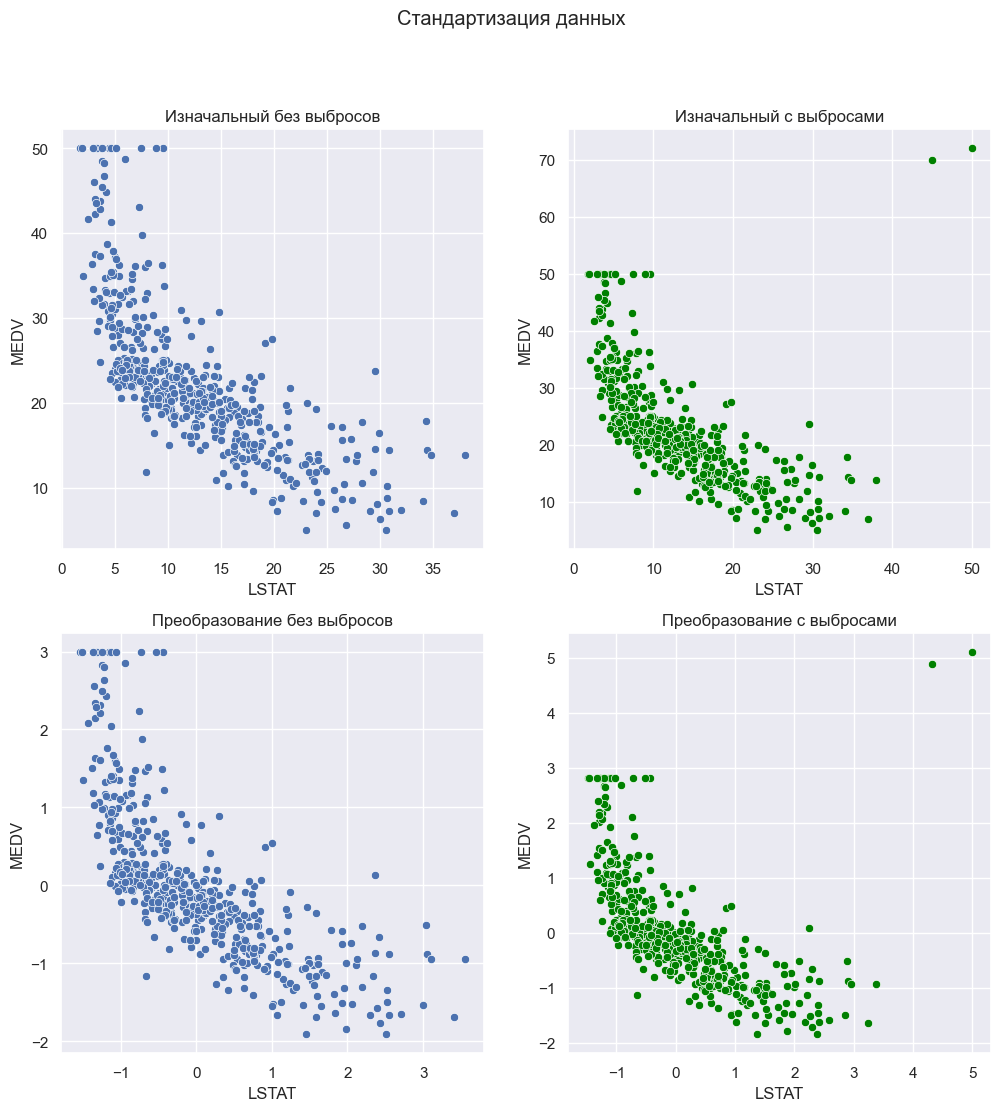

In [436]:
# применим эти функции
scatter_plots(
    boston,
    boston_outlier,
    boston_scaled,
    boston_outlier_scaled,
    title="Стандартизация данных",
)

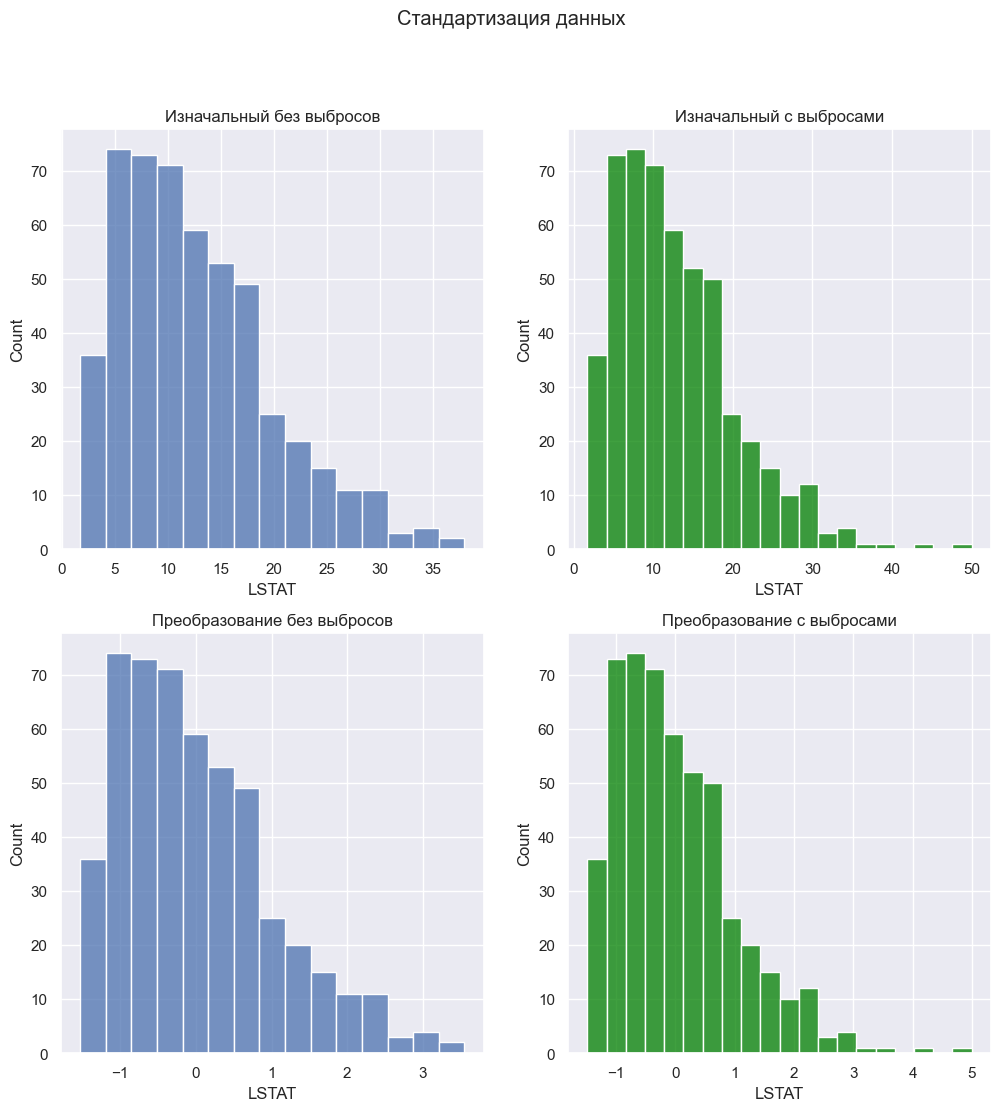

In [ ]:
hist_plots(boston,
           boston_outlier,
           boston_scaled,
           boston_outlier_scaled,
           title='Стандартизация данных')

Обратное преобразование

In [ ]:
# вернем исходный масштаб данных
boston_inverse = pd.DataFrame(st_scaler.inverse_transform(boston_scaled),
                              columns=boston.columns)

In [439]:
# используем метод .equals(), чтобы выяснить, одинаковы ли датафреймы
boston.equals(boston_inverse)

False

In [440]:
# вычтем значения одного датафрейма из значений другого
(boston - boston_inverse).head(3)

,LSTAT,MEDV
0,0.000000e+00,0.0
1,0.000000e+00,0.0
2,-8.881784e-16,0.0


In [441]:
# оценить приблизительное равенство можно так
np.all(np.isclose(boston.to_numpy(), boston_inverse.to_numpy()))

np.True_

#### Проблема утечки данных

In [442]:
# при return_X_y = True вместо объекта Bunch возвращаются признаки (X) 
# и целевая переменная (y)
# параметр as_frame = True возвращает датафрейм и Series вместо массивов 
# Numpy
a_var, b_var = fetch_california_housing(return_X_y=True, as_frame=True)

# убедимся, что данные в нужном нам формате
print(type(a_var), type(b_var))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [443]:
# посмотрим на признаки
a_var.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


In [444]:
X_train, X_test, y_train, y_test = train_test_split(a_var, b_var,
                                                    random_state=42)

In [445]:
# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

In [446]:
# масштабируем признаки обучающей выборки
X_train_scaled = scaler.fit_transform(X_train)

# убедимся, что объект scaler запомнил значения среднего и СКО
# для каждого признака
scaler.mean_, scaler.scale_

(array([ 3.87831412e+00,  2.85959948e+01,  5.43559839e+00,  1.09688116e+00,
         1.42749729e+03,  3.10665968e+00,  3.56467196e+01, -1.19583736e+02]),
 array([1.90372658e+00, 1.26109222e+01, 2.42157219e+00, 4.38789636e-01,
        1.14289394e+03, 1.19554480e+01, 2.13388067e+00, 2.00237697e+00]))

In [447]:
# применим масштабированные данные для обучения модели линейной регрессии
model = LinearRegression().fit(X_train_scaled, y_train)
model

LinearRegression()

In [ ]:
# преобразуем тестовые данные с использованием среднего и СКО, рассчитанных на 
# обучающей выборке
# так тестовые данные не повляют на обучение модели, и мы избежим утечки данных
X_test_scaled = scaler.transform(X_test)

# сделаем прогноз на стандартизированных тестовых данных
y_pred = model.predict(X_test_scaled)
y_pred[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

In [449]:
# и оценим R-квадрат (метрика (score) по умолчанию для класса LinearRegression)
model.score(X_test_scaled, y_test)

0.591050979549135

#### Применение пайплайна

##### Класс make_pipeline

In [450]:
# создадим объект pipe, в который поместим объекты классов StandardScaler 
# и LinearRegression
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [451]:
# одновременно применим масштабирование и создание модели регрессии на обучающей выборке
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [452]:
# теперь масштабируем тестовые данные (используя среднее и СКО обучающей части)
# и сделаем прогноз
pipe.predict(X_test)

array([0.72412832, 1.76677807, 2.71151581, ..., 1.72382152, 2.34689276,
       3.52917352], shape=(5160,))

In [453]:
# метод .score() выполнит масштабирование, обучит модель, сделает прогноз 
# и посчитает R-квадрат
pipe.score(X_test, y_test)

0.591050979549135

In [454]:
# сделать прогноз можно в одну строчку
make_pipeline(StandardScaler(), LinearRegression()).fit(X_train, y_train).predict(X_test)

array([0.72412832, 1.76677807, 2.71151581, ..., 1.72382152, 2.34689276,
       3.52917352], shape=(5160,))

In [455]:
# fmt: off
# как и посчитать R-квадрат
make_pipeline(
    StandardScaler(),
    LinearRegression(),
).fit(X_train, y_train).score(
    X_test,
    y_test,
)
# fmt: on

0.591050979549135

In [456]:
# под капотом мы создали объект класса Pipeline
type(pipe)

sklearn.pipeline.Pipeline

##### Класс Pipeline

In [457]:
# задаем названия и создаем объекты используемых классов
pipe = Pipeline(
    steps=[("scaler", StandardScaler()), ("lr", LinearRegression())], verbose=True
)

In [458]:
# рассчитаем коэффициент детерминации
pipe.fit(X_train, y_train).score(X_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s


0.591050979549135

### Приведение к диапазону

#### MinMaxScaler

In [459]:
# создаем объект этого класса,
# в параметре feature_range оставим диапазон по умолчанию
minmax = MinMaxScaler(feature_range=(0, 1))
minmax

MinMaxScaler()

In [460]:
# применим метод .fit() и
minmax.fit(boston)

# найдем минимальные и максимальные значения
minmax.data_min_, minmax.data_max_

(array([1.73, 5.  ]), array([37.97, 50.  ]))

In [461]:
# приведем данные без выбросов (достаточно метода .transform())
boston_scaled = minmax.transform(boston)
# и с выбросами к заданному диапазону
boston_outlier_scaled = minmax.fit_transform(boston_outlier)

# преобразуем результаты в датафрейм
boston_scaled = pd.DataFrame(boston_scaled, columns=boston.columns)
boston_outlier_scaled = pd.DataFrame(boston_outlier_scaled, columns=boston.columns)

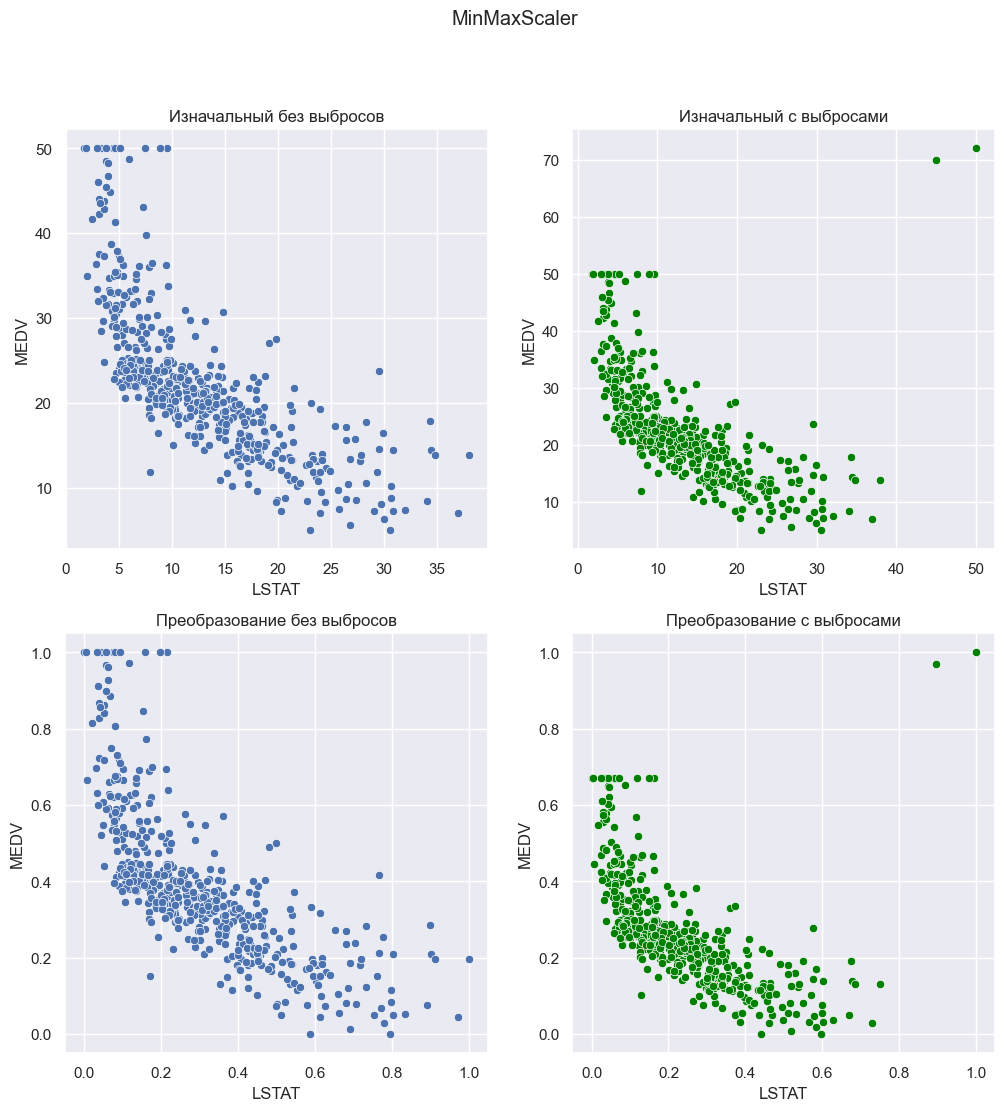

In [462]:
# построим точечные диаграммы
scatter_plots(
    boston, boston_outlier, boston_scaled, boston_outlier_scaled, title="MinMaxScaler"
)

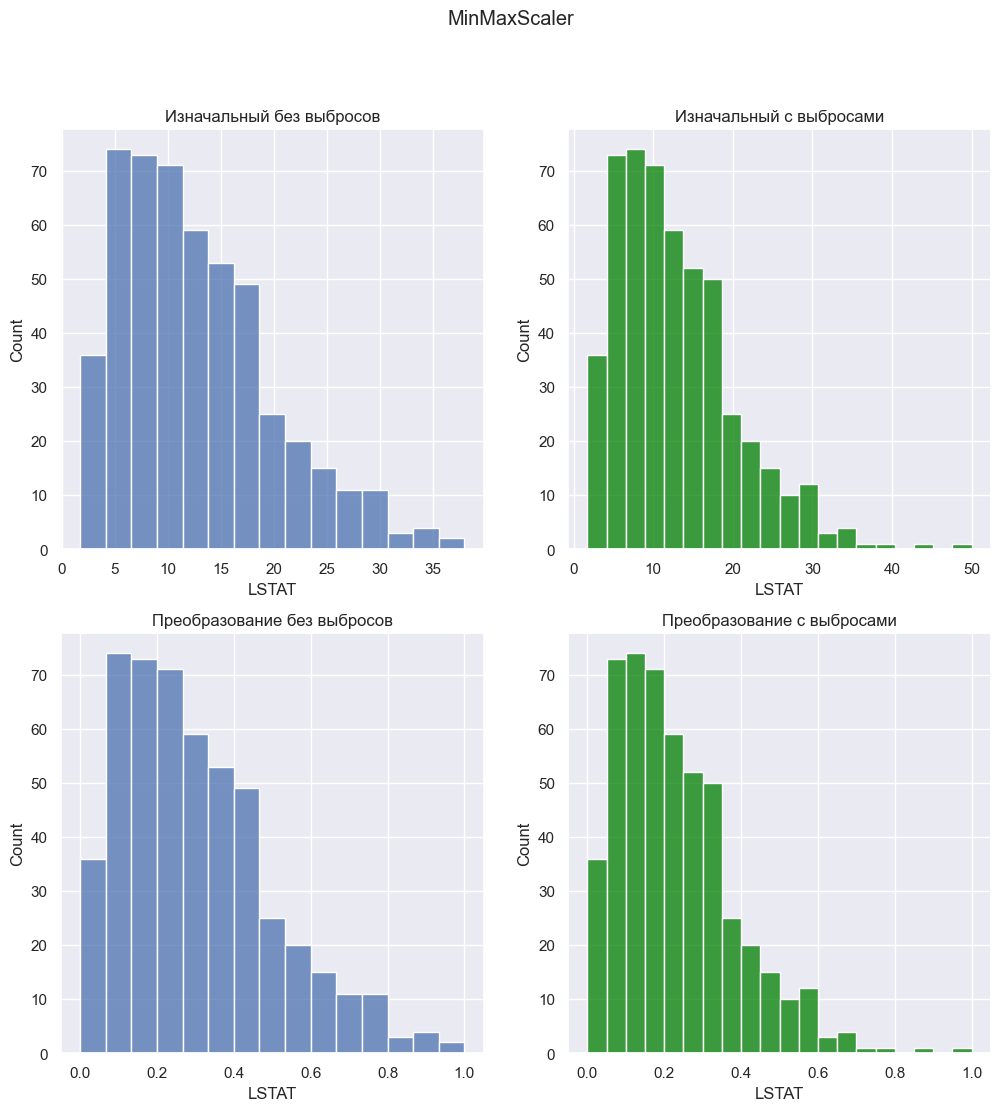

In [463]:
# и гистограммы
hist_plots(
    boston, boston_outlier, boston_scaled, boston_outlier_scaled, title="MinMaxScaler"
)

#### MaxAbsScaler

Стандартизация разреженной матрицы

In [464]:
# создадим разреженную матрицу с пятью признаками
sparse_dict: dict[str, list[float]] = {}

sparse_dict["F1"] = [0, 0, 1.25, 0, 2.15, 0, 0, 0, 0, 0, 0, 0]
sparse_dict["F2"] = [0, 0, 0, 0.45, 0, 1.20, 0, 0, 0, 1.28, 0, 0]
sparse_dict["F3"] = [0, 0, 0, 0, 2.15, 0, 0, 0, 0.33, 0, 0, 0]
sparse_dict["F4"] = [0, -6.5, 0, 0, 0, 0, 8.25, 0, 0, 0, 0, 0]
sparse_dict["F5"] = [0, 0, 0, 0, 0, 3.17, 0, 0, 0, 0, 0, -1.85]

sparse_data = pd.DataFrame(sparse_dict)
sparse_data

,F1,F2,F3,F4,F5
0,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,-6.50,0.00
2,1.25,0.00,0.00,0.00,0.00
3,0.00,0.45,0.00,0.00,0.00
4,2.15,0.00,2.15,0.00,0.00
5,0.00,1.20,0.00,0.00,3.17
6,0.00,0.00,0.00,8.25,0.00
7,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.33,0.00,0.00
9,0.00,1.28,0.00,0.00,0.00


In [465]:
# стандартизируем эти данные
pd.DataFrame(
    StandardScaler().fit_transform(sparse_data), columns=sparse_data.columns
).round(2)

,F1,F2,F3,F4,F5
0,-0.43,-0.53,-0.35,-0.05,-0.10
1,-0.43,-0.53,-0.35,-2.19,-0.10
2,1.47,-0.53,-0.35,-0.05,-0.10
3,-0.43,0.45,-0.35,-0.05,-0.10
4,2.83,-0.53,3.28,-0.05,-0.10
5,-0.43,2.07,-0.35,-0.05,2.90
6,-0.43,-0.53,-0.35,2.68,-0.10
7,-0.43,-0.53,-0.35,-0.05,-0.10
8,-0.43,-0.53,0.21,-0.05,-0.10
9,-0.43,2.24,-0.35,-0.05,-0.10


Простой пример

In [466]:
# создадим двумерный массив
arr = np.array([[1.0, -1.0, -2.0], [2.0, 0.0, 0.0], [0.0, 1.0, 1.0]])

In [467]:
maxabs = MaxAbsScaler()

maxabs.fit_transform(arr)

array([[ 0.5, -1. , -1. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. ,  0.5]])

In [468]:
# выведем модуль максимального значения каждого столбца
maxabs.scale_

array([2., 1., 2.])

In [469]:
pd.DataFrame(
    MaxAbsScaler().fit_transform(sparse_data), columns=sparse_data.columns
).round(2)

,F1,F2,F3,F4,F5
0,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,-0.79,0.00
2,0.58,0.00,0.00,0.00,0.00
3,0.00,0.35,0.00,0.00,0.00
4,1.00,0.00,1.00,0.00,0.00
5,0.00,0.94,0.00,0.00,1.00
6,0.00,0.00,0.00,1.00,0.00
7,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.15,0.00,0.00
9,0.00,1.00,0.00,0.00,0.00


Матрица csr и MaxAbsScaler

In [470]:
csr_data = csr_matrix(sparse_data.values)
print(csr_data)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (12, 5)>
  Coords	Values
  (1, 3)	-6.5
  (2, 0)	1.25
  (3, 1)	0.45
  (4, 0)	2.15
  (4, 2)	2.15
  (5, 1)	1.2
  (5, 4)	3.17
  (6, 3)	8.25
  (8, 2)	0.33
  (9, 1)	1.28
  (11, 4)	-1.85


In [471]:
# применим MaxAbsScaler
csr_data_scaled = MaxAbsScaler().fit_transform(csr_data)
print(csr_data_scaled)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (12, 5)>
  Coords	Values
  (1, 3)	-0.7878787878787878
  (2, 0)	0.5813953488372093
  (3, 1)	0.3515625
  (4, 0)	1.0
  (4, 2)	1.0
  (5, 1)	0.9375
  (5, 4)	0.9999999999999999
  (6, 3)	1.0
  (8, 2)	0.15348837209302327
  (9, 1)	1.0
  (11, 4)	-0.583596214511041


In [472]:
# восстановим плотную матрицу
csr_data_scaled.todense().round(2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.79,  0.  ],
       [ 0.58,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.35,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.94,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.15,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.58]])

### Robust scaling

In [473]:
boston_scaled = RobustScaler().fit_transform(boston)
boston_outlier_scaled = RobustScaler().fit_transform(boston_outlier)

boston_scaled = pd.DataFrame(boston_scaled, columns=boston.columns)
boston_outlier_scaled = pd.DataFrame(boston_outlier_scaled, columns=boston.columns)

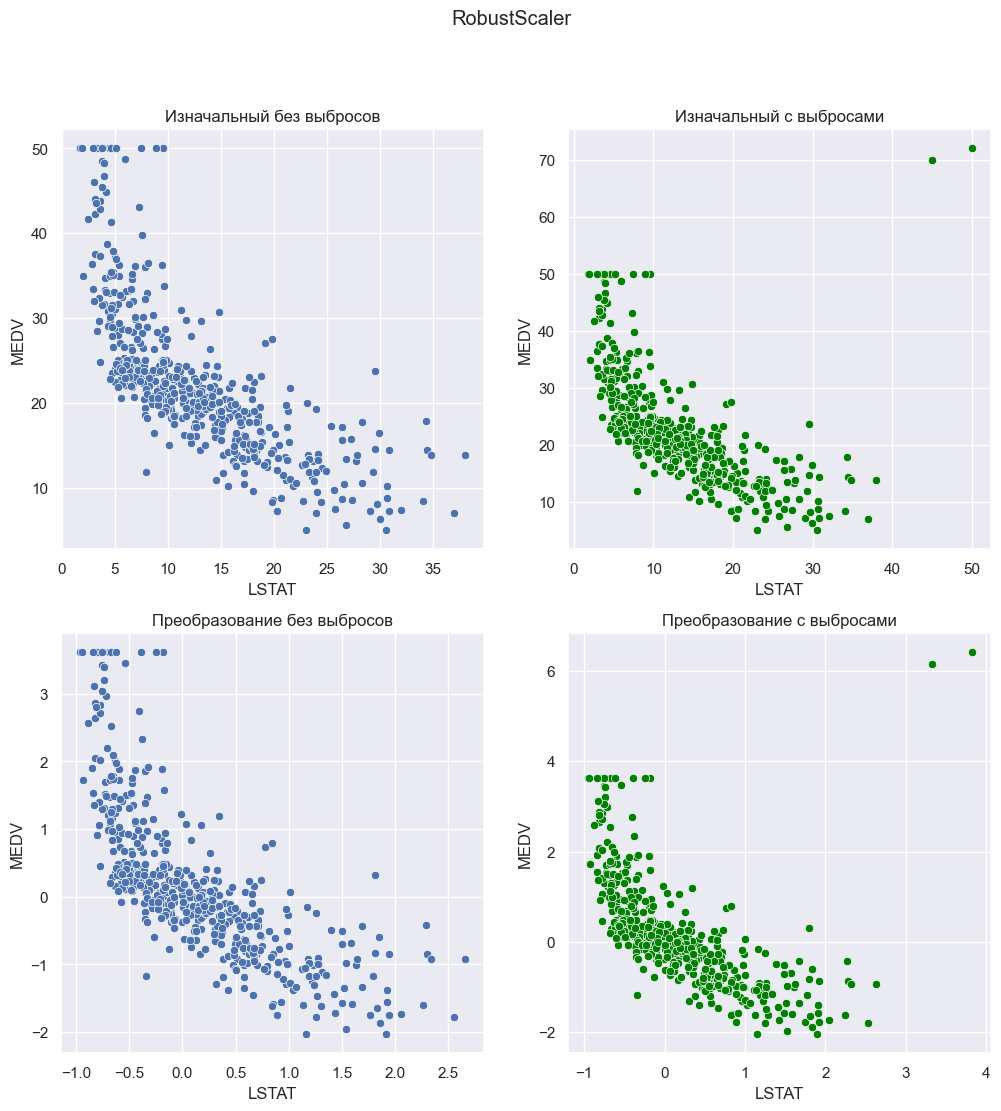

In [474]:
scatter_plots(
    boston, boston_outlier, boston_scaled, boston_outlier_scaled, title="RobustScaler"
)

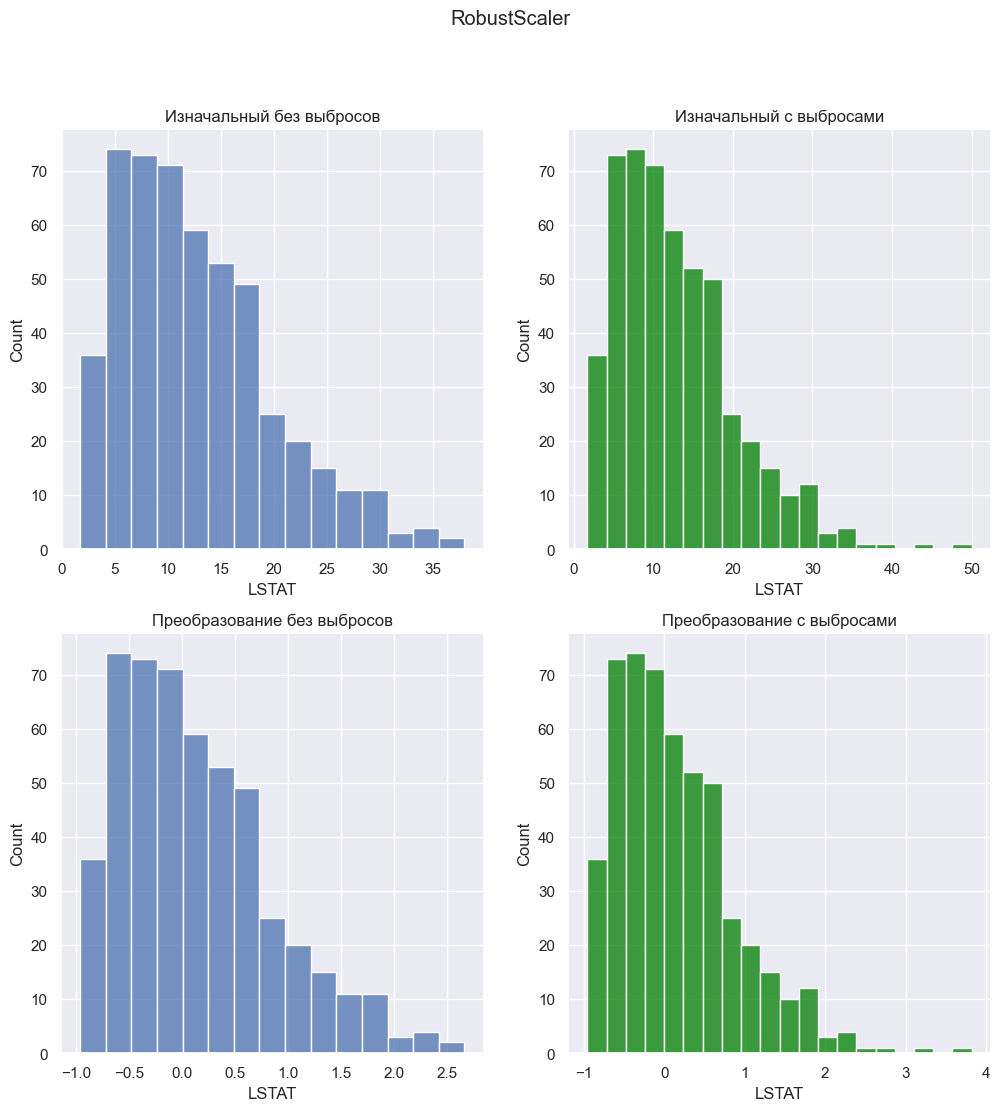

In [475]:
hist_plots(
    boston, boston_outlier, boston_scaled, boston_outlier_scaled, title="RobustScaler"
)

### Класс Normalizer

#### Норма вектора

In [476]:
# возьмем вектор с координатами [4, 3]
c_var = np.array([4, 3])

# и найдем его длину или L2 норму
l2norm = np.sqrt(c_var[0] ** 2 + c_var[1] ** 2)
l2norm

np.float64(5.0)

In [477]:
# разделим каждый компонент вектора на его норму
v_normalized = c_var / l2norm
v_normalized

array([0.8, 0.6])

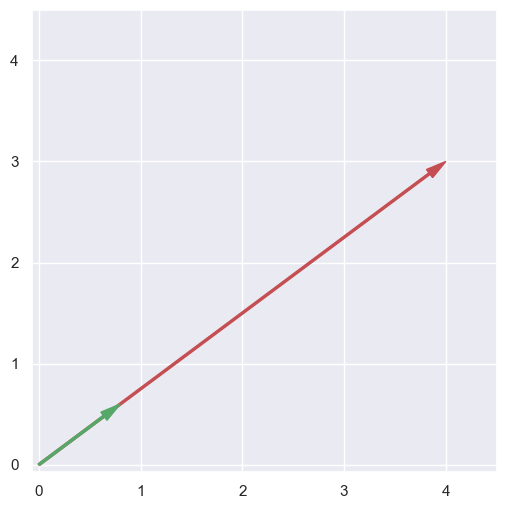

In [478]:
# выведем оба вектора на графике
plt.figure(figsize=(6, 6))

ax = plt.axes()

plt.xlim([-0.07, 4.5])
plt.ylim([-0.07, 4.5])

ax.arrow(
    0,
    0,
    c_var[0],
    c_var[1],
    width=0.02,
    head_width=0.1,
    head_length=0.2,
    length_includes_head=True,
    fc="r",
    ec="r",
)
ax.arrow(
    0,
    0,
    v_normalized[0],
    v_normalized[1],
    width=0.02,
    head_width=0.1,
    head_length=0.2,
    length_includes_head=True,
    fc="g",
    ec="g",
)

plt.show()

#### L2 нормализация

In [479]:
# возьмем простой двумерный массив (каждая строка - это вектор)
arr = np.array([[45, 30], [12, -340], [-125, 4]])

In [480]:
# найдем L2 норму первого вектора
np.sqrt(arr[0][0] ** 2 + arr[0][1] ** 2)

np.float64(54.08326913195984)

In [481]:
# в цикле пройдемся по строкам
for row in arr:
    # найдем L2 норму каждого вектора-строки
    l2norm = np.sqrt(row[0] ** 2 + row[1] ** 2)
    # и разделим на нее каждый из компонентов вектора
    print((row[0] / l2norm).round(8), (row[1] / l2norm).round(8))

0.83205029 0.5547002
0.03527216 -0.99937774
-0.99948839 0.03198363


In [482]:
# убедимся, что L2 нормализация выполнена верно,
# подставив в формулу Евклидова расстояния новые координаты
np.sqrt(0.83205029**2 + 0.5547002**2).round(3)

np.float64(1.0)

In [483]:
Normalizer().fit_transform(arr)

array([[ 0.83205029,  0.5547002 ],
       [ 0.03527216, -0.99937774],
       [-0.99948839,  0.03198363]])

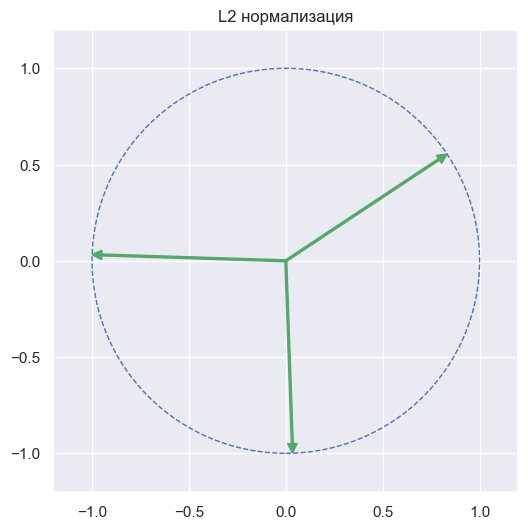

In [484]:
# fmt: off
plt.figure(figsize=(6, 6))

ax = plt.axes()

# в цикле нормализуем каждый из векторов
for d_var in Normalizer().fit_transform(arr):
    # и выведем его на графике в виде стрелки
    ax.arrow(
        0,
        0,
        d_var[0],
        d_var[1],
        width=0.01,
        head_width=0.05,
        head_length=0.05,
        length_includes_head=True,
        fc="g",
        ec="g",
    )

# добавим единичную окружность
circ = plt.Circle(
    (0, 0),
    radius=1,
    edgecolor="b",
    facecolor="None",
    linestyle="--",
)
ax.add_patch(circ)

plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])

plt.title('L2 нормализация')

plt.show()
# fmt: on

Опасность нормализации по строкам

In [485]:
# данные о росте, весе и возрасте людей
people = np.array([[180, 80, 50], [170, 73, 50]])

In [486]:
# получается, что у них разный возраст
Normalizer().fit_transform(people)

array([[0.8857221 , 0.39365427, 0.24603392],
       [0.88704238, 0.38090643, 0.26089482]])

#### L1 нормализация

In [487]:
# возьмем тот же массив
arr

array([[  45,   30],
       [  12, -340],
       [-125,    4]])

In [488]:
# рассчитаем L1 норму для первой строки
print(np.abs(arr[0][0]) + np.abs(arr[0][1]))

75


In [489]:
# вновь пройдемся по каждому вектору
for row in arr:
    # найдем соответствующую L1 норму
    l1norm = np.abs(row[0]) + np.abs(row[1])
    # и нормализуем векторы
    print((row[0] / l1norm).round(8), (row[1] / l1norm).round(8))

0.6 0.4
0.03409091 -0.96590909
-0.96899225 0.03100775


In [490]:
# убедимся в том, что вторая вектор-строка имеет единичную
# L1 норму
print(np.abs(0.03409091) + np.abs(-0.96590909))

1.0


In [491]:
# через параметр norm = 'l1' укажем,
# что хотим провести L1 нормализацию
Normalizer(norm="l1").fit_transform(arr)

array([[ 0.6       ,  0.4       ],
       [ 0.03409091, -0.96590909],
       [-0.96899225,  0.03100775]])

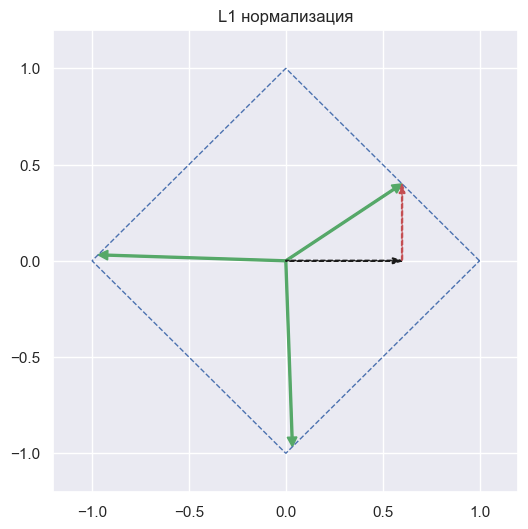

In [492]:
plt.figure(figsize=(6, 6))
ax = plt.axes()

# выведем L1 нормализованные векторы
for e_var in Normalizer(norm="l1").fit_transform(arr):
    ax.arrow(
        0,
        0,
        e_var[0],
        e_var[1],
        width=0.01,
        head_width=0.05,
        head_length=0.05,
        length_includes_head=True,
        fc="g",
        ec="g",
    )

# то, как рассчитывалось расстояние до первого вектора
ax.arrow(
    0,
    0,
    0.6,
    0,
    width=0.005,
    head_width=0.03,
    head_length=0.05,
    length_includes_head=True,
    fc="k",
    ec="k",
    linestyle="--",
)
ax.arrow(
    0.6,
    0,
    0,
    0.4,
    width=0.005,
    head_width=0.03,
    head_length=0.05,
    length_includes_head=True,
    fc="r",
    ec="r",
    linestyle="--",
)

# а также границы единичных векторов при L1 нормализации
points = [[1, 0], [0, 1], [-1, 0], [0, -1]]
polygon = plt.Polygon(points, fill=None, edgecolor="b", linestyle="--")
ax.add_patch(polygon)

plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])

plt.title("L1 нормализация")

plt.show()

#### Нормализация Чебышёва

In [493]:
arr

array([[  45,   30],
       [  12, -340],
       [-125,    4]])

In [494]:
# найдем расстояние Чебышёва для первого вектора
max(np.abs(arr[0][0]), np.abs(arr[0][1]))

np.int64(45)

In [495]:
# теперь для всего массива
for row in arr:
    # найдем соответствующую норму Чебышёва
    l_inf = max(np.abs(row[0]), np.abs(row[1]))
    # и нормализуем векторы
    print((row[0] / l_inf).round(8), (row[1] / l_inf).round(8))

1.0 0.66666667
0.03529412 -1.0
-1.0 0.032


In [496]:
# сделаем то же самое с помощью класс Normalizer
Normalizer(norm="max").fit_transform(arr)

array([[ 1.        ,  0.66666667],
       [ 0.03529412, -1.        ],
       [-1.        ,  0.032     ]])

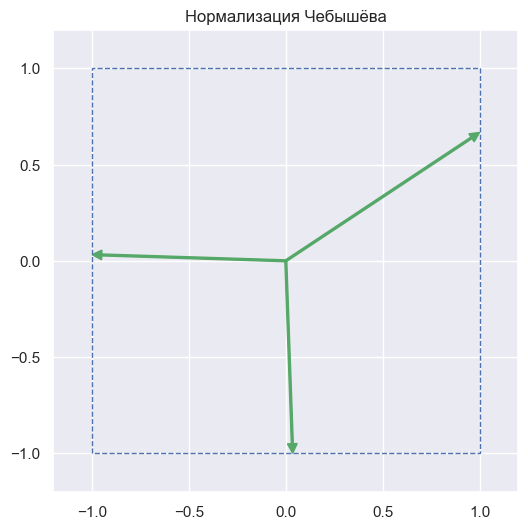

In [497]:
plt.figure(figsize=(6, 6))
ax = plt.axes()

# выведем нормализованные по расстоянию Чебышёва векторы,
for f_var in Normalizer(norm="max").fit_transform(arr):
    ax.arrow(
        0,
        0,
        f_var[0],
        f_var[1],
        width=0.01,
        head_width=0.05,
        head_length=0.05,
        length_includes_head=True,
        fc="g",
        ec="g",
    )

# а также границы единичных векторов при такой нормализации
points = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
polygon = plt.Polygon(points, fill=None, edgecolor="b", linestyle="--")
ax.add_patch(polygon)

plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])

plt.title("Нормализация Чебышёва")

plt.show()

## Нелинейные преобразования

In [ ]:
load_dotenv()

boston_csv_url = os.environ.get("BOSTON_CSV_URL", "")
response = requests.get(boston_csv_url)

# вновь подгрузим полный датасет boston
boston = pd.read_csv(io.BytesIO(response.content))

#### Логарифмическое преобразование

##### Смысл логарифмического преобразования

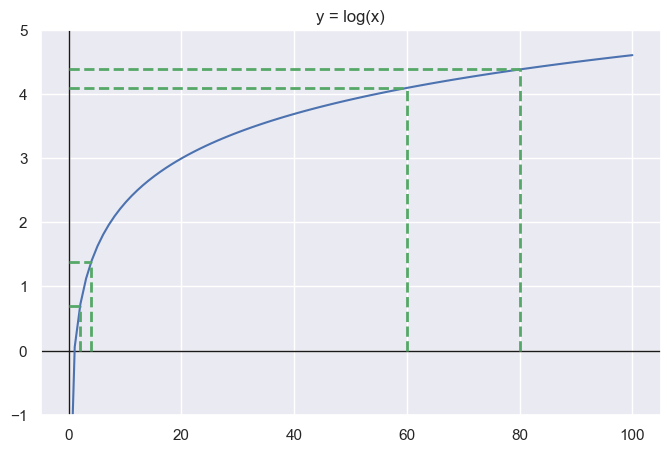

In [499]:
# построим график логарифмической функции
x = np.linspace(0.05, 100, 100)  # noqa
y = np.log(x)  # noqa

ax = plt.axes()

plt.xlim([-5, 105])
plt.ylim([-1, 5])

ax.hlines(y=0, xmin=-5, xmax=105, linewidth=1, color="k")
ax.vlines(x=0, ymin=-1, ymax=5, linewidth=1, color="k")

plt.plot(x, y)

# и посмотрим, как она поступает с промежутками между небольшими
ax.vlines(x=2, ymin=0, ymax=np.log(2), linewidth=2, color="g", linestyles="--")
ax.vlines(x=4, ymin=0, ymax=np.log(4), linewidth=2, color="g", linestyles="--")
ax.hlines(y=np.log(2), xmin=0, xmax=2, linewidth=2, color="g", linestyles="--")
ax.hlines(y=np.log(4), xmin=0, xmax=4, linewidth=2, color="g", linestyles="--")

# и большими значениями
ax.vlines(x=60, ymin=0, ymax=np.log(60), linewidth=2, color="g", linestyles="--")
ax.vlines(x=80, ymin=0, ymax=np.log(80), linewidth=2, color="g", linestyles="--")
ax.hlines(y=np.log(60), xmin=0, xmax=60, linewidth=2, color="g", linestyles="--")
ax.hlines(y=np.log(80), xmin=0, xmax=80, linewidth=2, color="g", linestyles="--")

plt.title("y = log(x)")

plt.show()

##### Скошенное вправо распределение

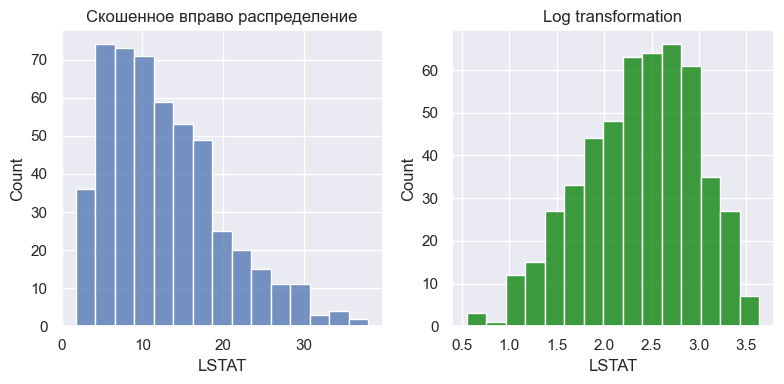

In [500]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(x=boston.LSTAT, bins=15, ax=ax[0])
ax[0].set_title("Скошенное вправо распределение")

sns.histplot(x=np.log(boston.LSTAT), bins=15, color="green", ax=ax[1])
ax[1].set_title("Log transformation")

plt.tight_layout()
plt.show()

In [501]:
# рассчитаем ассиметричность до и после преобразования
print(skew(boston.LSTAT), skew(np.log(boston.LSTAT)))

0.9037707431346133 -0.3192822699479382


In [502]:
# рассчитаем коэффициент эксцесса до и после преобразования
print(kurtosis(boston.LSTAT), kurtosis(np.log(boston.LSTAT)))

0.476544755729746 -0.4390590293275558


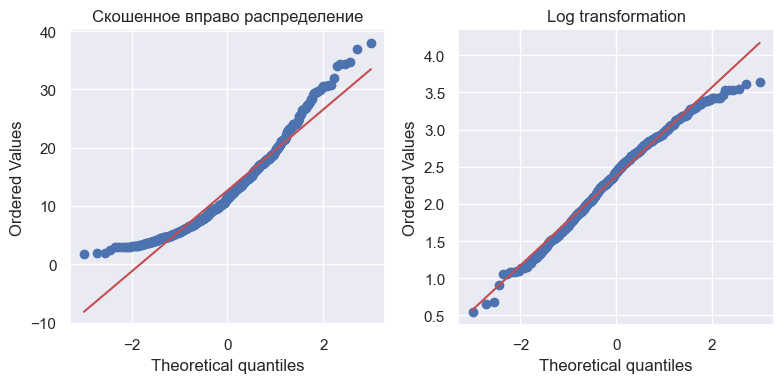

In [503]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

probplot(boston.LSTAT, dist="norm", plot=ax[0])
ax[0].set_title("Скошенное вправо распределение")

probplot(np.log(boston.LSTAT), dist="norm", plot=ax[1])
ax[1].set_title("Log transformation")

plt.tight_layout()
plt.show()

Влияние логарифмического преобразования на выбросы

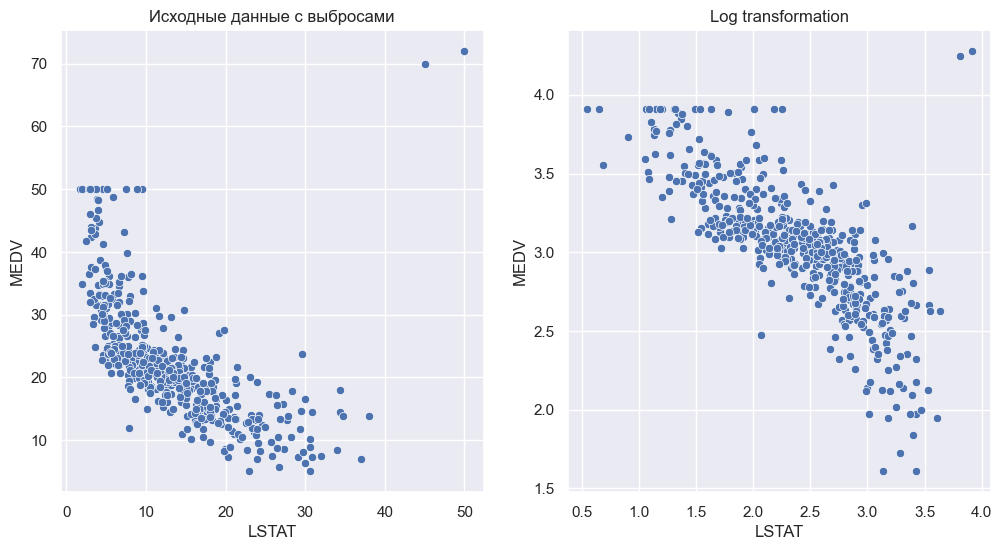

In [504]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x=boston_outlier.LSTAT, y=boston_outlier.MEDV, ax=ax[0]).set(
    title="Исходные данные с выбросами"
)
sns.scatterplot(
    x=np.log(boston_outlier.LSTAT), y=np.log(boston_outlier.MEDV), ax=ax[1]
).set(title="Log transformation");

##### Скошенное влево распределение

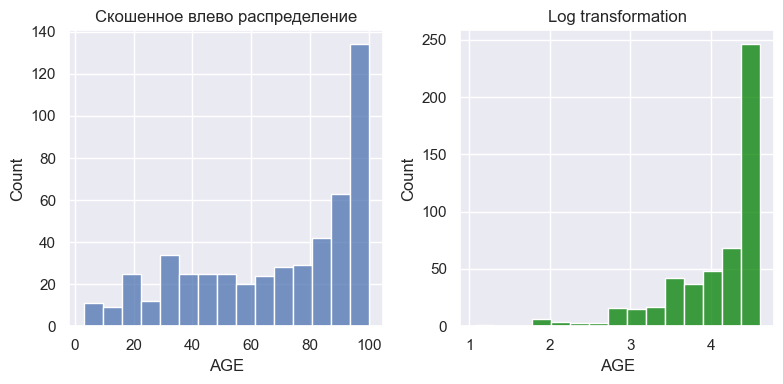

In [505]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(x=boston.AGE, bins=15, ax=ax[0])
ax[0].set_title("Скошенное влево распределение")

sns.histplot(x=np.log(boston.AGE), bins=15, color="green", ax=ax[1])
ax[1].set_title("Log transformation")

plt.tight_layout()
plt.show()

In [506]:
print(skew(boston.AGE), skew(np.log(boston.AGE)))

-0.5971855948016143 -1.6706835909283215


In [507]:
print(kurtosis(boston.AGE), kurtosis(np.log(boston.AGE)))

-0.97001392664039 2.907332087827127


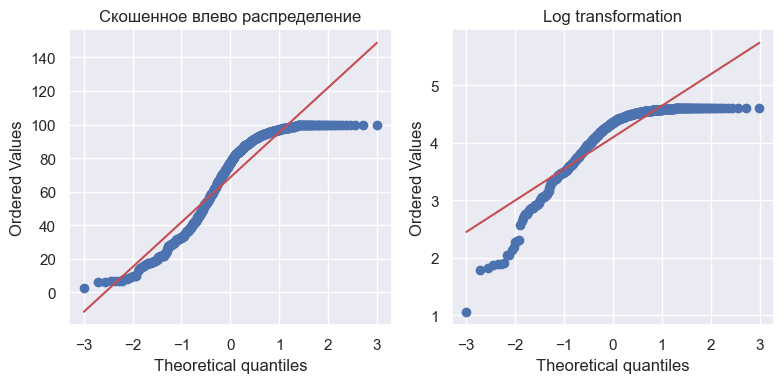

In [508]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

probplot(boston.AGE, dist="norm", plot=ax[0])
ax[0].set_title("Скошенное влево распределение")

probplot(np.log(boston.AGE), dist="norm", plot=ax[1])
ax[1].set_title("Log transformation")

plt.tight_layout()
plt.show()

##### Логарифм нуля и отрицательных значений

In [509]:
# в переменной ZN есть нулевые значения
# добавим к переменной небольшую константу
print(np.log(boston.ZN + 0.0001)[:5])  # type: ignore[index]

0    2.890377
1   -9.210340
2   -9.210340
3   -9.210340
4   -9.210340
Name: ZN, dtype: float64


In [510]:
# можно использовать преобразование обратного гиперболического синуса
print(np.log(boston.ZN + np.sqrt(boston.ZN**2 + 1))[:5])  # type: ignore[index]

0    3.58429
1    0.00000
2    0.00000
3    0.00000
4    0.00000
Name: ZN, dtype: float64


In [511]:
np.log(-10 + np.sqrt((-10) ** 2 + 1))

np.float64(-2.998222950297976)

##### Основание логарифма

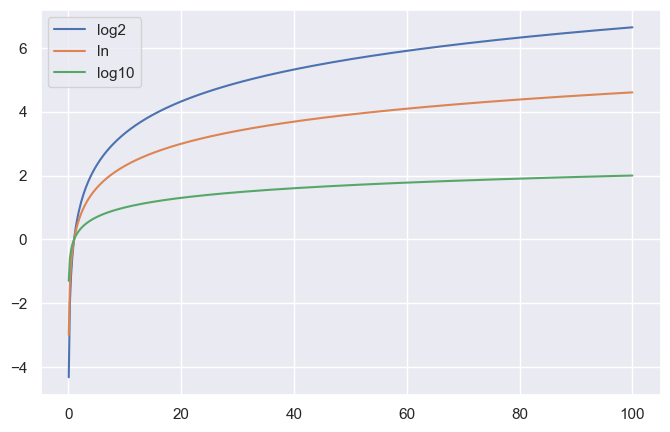

In [512]:
i_var = np.linspace(0.05, 100, 500)
y_2 = np.log2(i_var)
y_ln = np.log(i_var)
y_10 = np.log10(i_var)

plt.plot(i_var, y_2, label="log2")
plt.plot(i_var, y_ln, label="ln")
plt.plot(i_var, y_10, label="log10")

plt.legend()

plt.show()

##### Линейная взаимосвязь

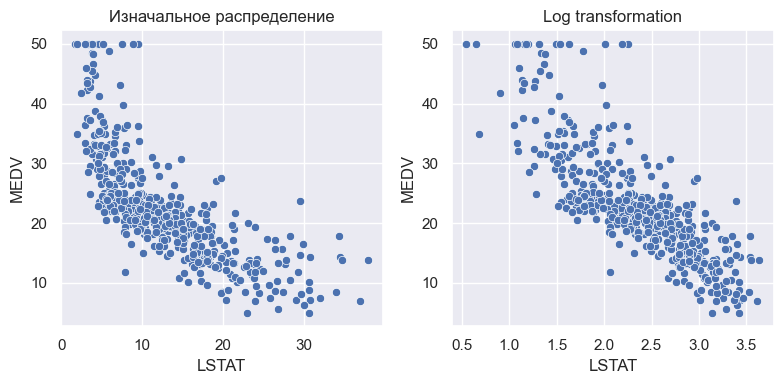

In [513]:
# визуально оценим "выпрямление" данных
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.scatterplot(x=boston.LSTAT, y=boston.MEDV, ax=ax[0])
ax[0].set_title("Изначальное распределение")

sns.scatterplot(x=np.log(boston.LSTAT), y=boston.MEDV, ax=ax[1])
ax[1].set_title("Log transformation")

plt.tight_layout()

plt.show()

In [514]:
# посмотрим, как изменится корреляция, если преобразовать
# одну, вторую или сразу обе переменные
boston["LSTAT_log"] = np.log(boston["LSTAT"])
boston["MEDV_log"] = np.log(boston["MEDV"])

boston[["LSTAT", "LSTAT_log", "MEDV", "MEDV_log"]].corr()

,LSTAT,LSTAT_log,MEDV,MEDV_log
LSTAT,1.000000,0.944031,-0.737663,-0.805034
LSTAT_log,0.944031,1.000000,-0.815442,-0.822960
MEDV,-0.737663,-0.815442,1.000000,0.953155
MEDV_log,-0.805034,-0.822960,0.953155,1.000000


In [515]:
# сравним исходный датасет и лог-преобразование + обратную операцию
# (округлим значения, чтобы ошибка округления не мешала сравнению)
boston.MEDV.round(2).equals(np.exp(np.log(boston.MEDV)).round(2))

True

#### Преобразование квадратного корня

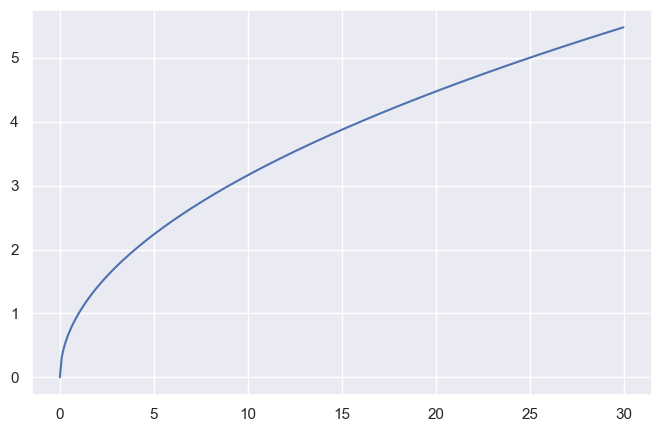

In [516]:
j_var = np.linspace(0, 30, 300)
k_var = np.sqrt(j_var)

plt.plot(j_var, k_var);

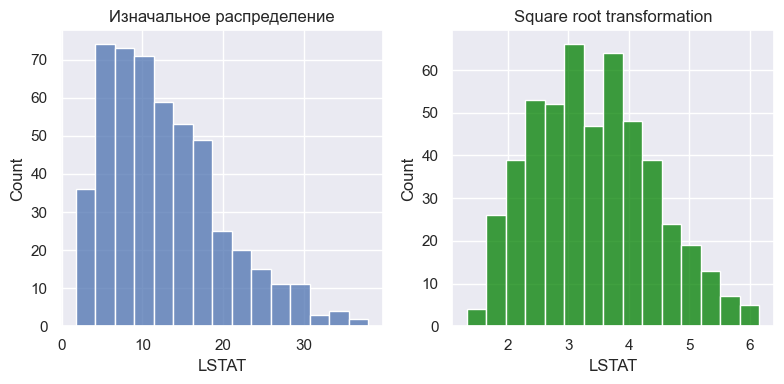

In [517]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(x=boston.LSTAT, bins=15, ax=ax[0])
ax[0].set_title("Изначальное распределение")

sns.histplot(x=np.sqrt(boston.LSTAT), bins=15, color="green", ax=ax[1])
ax[1].set_title("Square root transformation")

plt.tight_layout()
plt.show()

In [518]:
print(skew(np.sqrt(boston.LSTAT)), kurtosis(np.sqrt(boston.LSTAT)))

0.30647851994358943 -0.4830777032469129


In [519]:
boston["LSTAT_sqrt"] = np.sqrt(boston["LSTAT"])
boston["MEDV_sqrt"] = np.sqrt(boston["MEDV"])

boston[["LSTAT", "LSTAT_sqrt", "MEDV", "MEDV_sqrt"]].corr()

,LSTAT,LSTAT_sqrt,MEDV,MEDV_sqrt
LSTAT,1.000000,0.986688,-0.737663,-0.781287
LSTAT_sqrt,0.986688,1.000000,-0.785109,-0.816253
MEDV,-0.737663,-0.785109,1.000000,0.989148
MEDV_sqrt,-0.781287,-0.816253,0.989148,1.000000


#### Лестница степеней Тьюки

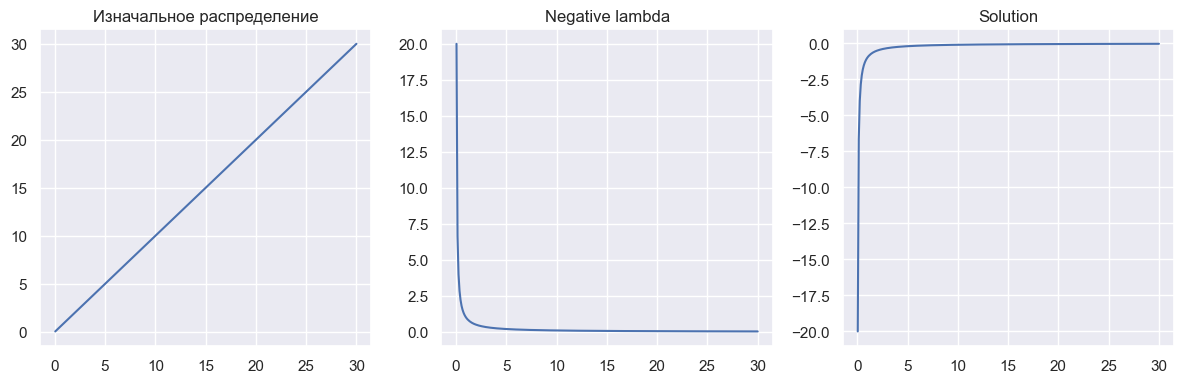

In [520]:
l_var = np.linspace(0.05, 30, 300)

y0 = l_var
y1 = l_var ** (-1)
y2 = -(l_var ** (-1))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].plot(l_var, y0)
ax[0].set_title("Изначальное распределение")

ax[1].plot(l_var, y1)
ax[1].set_title("Negative lambda")

ax[2].plot(l_var, y2)
ax[2].set_title("Solution")

plt.tight_layout()

plt.show()

In [ ]:
def tukey(
    m_var: pd.Series[float],
    n_var: pd.Series[float],
) -> tuple[float, float]:
    """Compute Tukey's transformation to maximize certain correlation."""
    m_arr, n_arr = m_var.to_numpy(), n_var.to_numpy()

    # в lambdas поместим возможные степени
    lambdas = [-2, -1, -0.5, 0, 0.5, 1, 2]
    # в corrs будем записывать получающиеся корреляции
    corrs: list[float] = []

    # в цикле последовательно применим каждую lambda
    for o_var in lambdas:
        if o_var < 0:
            # рассчитаем коэффициент корреляции Пирсона и добавим результат в corrs
            corrs.append(np.corrcoef(m_arr**o_var, n_arr**o_var)[0, 1])

        elif o_var == 0:
            corrs.append(
                np.corrcoef(
                    np.log(m_arr + np.sqrt(m_arr**2 + 1)),
                    np.log(n_arr + np.sqrt(n_arr**2 + 1)),
                )[0, 1]
            )

        else:
            corrs.append(np.corrcoef(-(m_arr**o_var), -(n_arr**o_var))[0, 1])

    # теперь найдем индекс наибольшего значения корреляции
    idx = int(np.argmax(np.abs(corrs)))

    # выведем оптимальную lambda и соответствующую корреляцию
    return lambdas[idx], float(np.round(corrs[idx], 3))

In [522]:
# найдем оптимальную lambda для LSTAT
tukey(boston.LSTAT, boston.MEDV)

(0, -0.824)

In [523]:
# найдем оптимальные lambda для каждого признака
for col in boston[
    ["CRIM", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "LSTAT"]
]:
    print(str(col) + "\t" + str(tukey(boston[col], boston.MEDV)))

CRIM	(0, -0.593)
NOX	(-0.5, -0.526)
RM	(2, 0.724)
AGE	(0.5, -0.402)
DIS	(-1, 0.489)
RAD	(0, -0.44)
TAX	(-0.5, -0.558)
PTRATIO	(0.5, -0.509)
LSTAT	(0, -0.824)


In [524]:
# рассчитаем корреляцию признаков до преобразования с целевой переменной
boston[
    ["CRIM", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "LSTAT", "MEDV"]
].corr().MEDV.round(2)

CRIM      -0.39
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [525]:
# создадим датафрейм с преобразованными данными
# boston_transformed = {}

# boston_transformed["RM"] = boston.RM**2
# boston_transformed["PTRATIO"] = np.sqrt(boston.PTRATIO)
# boston_transformed["LSTAT"] = np.log(boston.LSTAT)
# boston_transformed["MEDV"] = boston.MEDV

# boston_transformed = pd.DataFrame(
#     boston_transformed, columns=["RM", "PTRATIO", "LSTAT", "MEDV"]
# )

boston_transformed = pd.DataFrame(
    {
        "RM": boston.RM**2,
        "PTRATIO": np.sqrt(boston.PTRATIO.to_numpy()),
        "LSTAT": np.log(boston.LSTAT.to_numpy()),
        "MEDV": boston.MEDV,
    }
)


boston_transformed.head()

,RM,PTRATIO,LSTAT,MEDV
0,43.230625,3.911521,1.605430,24.0
1,41.229241,4.219005,2.212660,21.6
2,51.624225,4.219005,1.393766,34.7
3,48.972004,4.324350,1.078410,33.4
4,51.079609,4.324350,1.673351,36.2


In [526]:
model = LinearRegression()
model.fit(boston[["RM", "PTRATIO", "LSTAT"]], boston.MEDV)
model.score(boston[["RM", "PTRATIO", "LSTAT"]], boston.MEDV)

0.6786241601613111

In [527]:
model = LinearRegression()
model.fit(boston_transformed[["RM", "PTRATIO", "LSTAT"]], boston_transformed.MEDV)
model.score(boston_transformed[["RM", "PTRATIO", "LSTAT"]], boston_transformed.MEDV)

0.7446785206677596

#### Преобразование Бокса-Кокса

In [528]:
pt = PowerTransformer(method="box-cox")

# найдем оптимальный параметр лямбда
pt.fit(boston[["LSTAT"]])

pt.lambdas_

array([0.22776735])

In [529]:
# преобразуем данные
bc_pt = pt.transform(boston[["LSTAT"]])

# метод .transform() возвращает двумерный массив
bc_pt.shape

(506, 1)

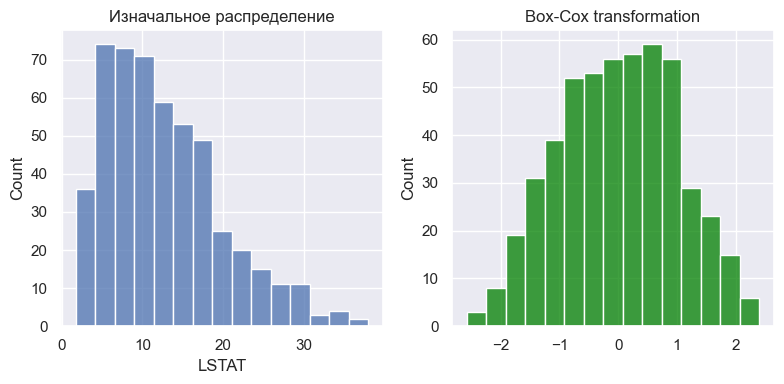

In [530]:
# сравним изначальное распределение и распределение после преобразования Бокса-Кокса
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(x=boston.LSTAT, bins=15, ax=ax[0])
ax[0].set_title("Изначальное распределение")

# так как на выходе метод .transform() выдает двумерный массив,
# его необходимо преобразовать в одномерный
sns.histplot(x=bc_pt.flatten(), bins=15, color="green", ax=ax[1])
ax[1].set_title("Box-Cox transformation")

plt.tight_layout()
plt.show()

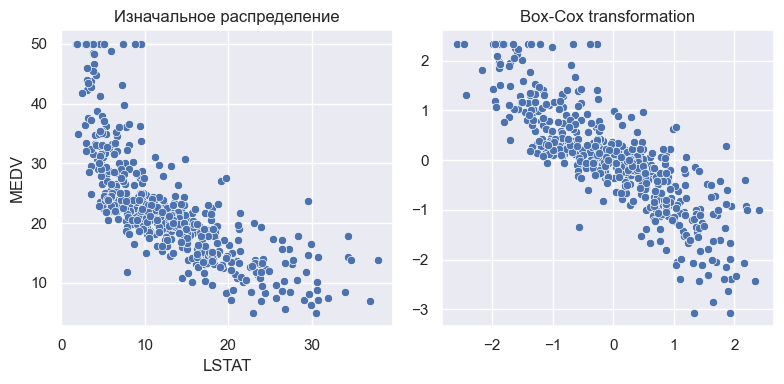

In [531]:
# оценим изменение взаимосвязи после преобразования Бокса-Кокса
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.scatterplot(x=boston.LSTAT, y=boston.MEDV, ax=ax[0])
ax[0].set_title("Изначальное распределение")

# можно использовать функцию power_transform(),
# она действует аналогично классу, но без estimator
sns.scatterplot(
    x=power_transform(boston[["LSTAT"]], method="box-cox").flatten(),
    y=power_transform(boston[["MEDV"]], method="box-cox").flatten(),
    ax=ax[1],
)
ax[1].set_title("Box-Cox transformation")

plt.tight_layout()

plt.show()

In [532]:
# посмотрим на достигнутый коэффициент корреляции
pd.DataFrame(
    power_transform(boston[["LSTAT", "MEDV"]], method="box-cox"),
    columns=[["LSTAT", "MEDV"]],
).corr()

,LSTAT,MEDV
LSTAT,1.000000,-0.830424
MEDV,-0.830424,1.000000


In [533]:
# сравним корреляцию признаков с целевой переменной
# после преобразования Бокса-Кокса
MEDV_bc = power_transform(boston[["MEDV"]], method="box-cox").flatten()

# for col in boston[
#     ["CRIM", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "LSTAT"]
# ]:
#     col_bc = power_transform(boston[[col]], method="box-cox").flatten()
#     print(col + "\t" + str(np.round(np.corrcoef(col_bc, MEDV_bc)[0][1], 3)))

for col in ["CRIM", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "LSTAT"]:
    col_bc = power_transform(boston[[col]], method="box-cox").flatten()
    print(f"{col}\t{np.round(np.corrcoef(col_bc, MEDV_bc)[0][1], 3)}")

CRIM	-0.528
NOX	-0.5
RM	0.64
AGE	-0.452
DIS	0.392
RAD	-0.403
TAX	-0.538
PTRATIO	-0.522
LSTAT	-0.83


In [534]:
# возьмем признаки RM, PTRATIO, LSTAT и целевую переменную MEDV
# и применим преобразование
pt = PowerTransformer(method="box-cox")
boston_bc = pt.fit_transform(boston[["RM", "PTRATIO", "LSTAT", "MEDV"]])
boston_bc = pd.DataFrame(boston_bc, columns=["RM", "PTRATIO", "LSTAT", "MEDV"])

# построим линейную регрессию
# в данном случае показатель чуть хуже, чем при лестнице Тьюки
model = LinearRegression()
model.fit(boston_bc[["RM", "PTRATIO", "LSTAT"]], boston_bc.MEDV)
model.score(boston_bc[["RM", "PTRATIO", "LSTAT"]], boston_bc.MEDV)

0.7331845214773436

In [535]:
# посмотрим на лямбды
pt.lambdas_

array([0.44895976, 4.35021552, 0.22776735, 0.21662091])

In [536]:
# выполним обратное преобразование
pd.DataFrame(
    pt.inverse_transform(boston_bc), columns=["RM", "PTRATIO", "LSTAT", "MEDV"]
).head()

,RM,PTRATIO,LSTAT,MEDV
0,6.575,15.3,4.98,24.0
1,6.421,17.8,9.14,21.6
2,7.185,17.8,4.03,34.7
3,6.998,18.7,2.94,33.4
4,7.147,18.7,5.33,36.2


#### Преобразование Йео-Джонсона

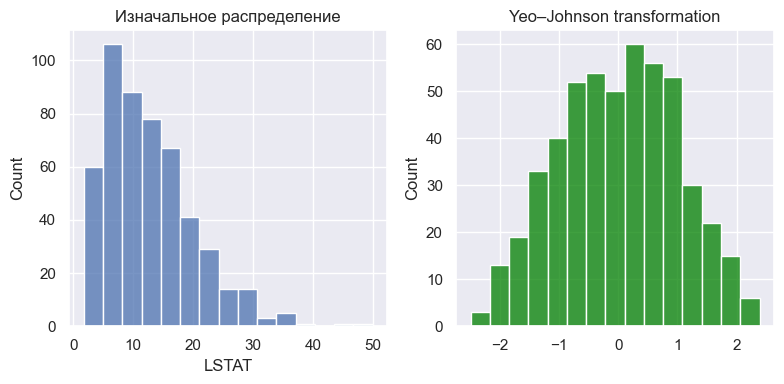

In [537]:
# попробуем преобразование Йео-Джонсона
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(x=boston_outlier.LSTAT, bins=15, ax=ax[0])
ax[0].set_title("Изначальное распределение")

sns.histplot(
    x=power_transform(boston[["LSTAT"]], method="yeo-johnson").flatten(),
    bins=15,
    color="green",
    ax=ax[1],
)
ax[1].set_title("Yeo–Johnson transformation")

plt.tight_layout()
plt.show()

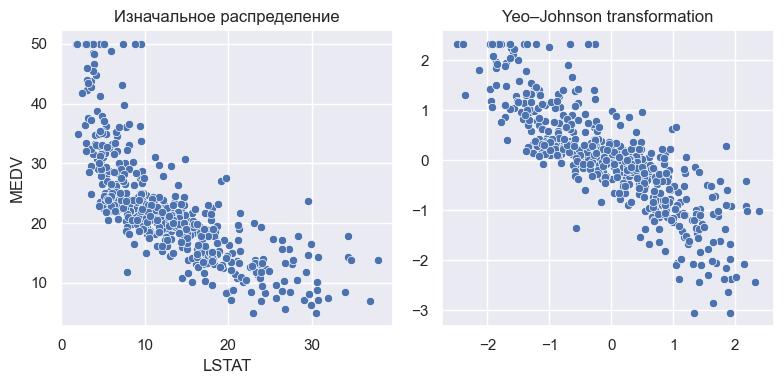

In [538]:
# посмотрим, как изменится линейность взаимосвязи
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.scatterplot(x=boston.LSTAT, y=boston.MEDV, ax=ax[0])
ax[0].set_title("Изначальное распределение")

sns.scatterplot(
    x=power_transform(boston[["LSTAT"]], method="yeo-johnson").flatten(),
    y=power_transform(boston[["MEDV"]], method="yeo-johnson").flatten(),
    ax=ax[1],
)
ax[1].set_title("Yeo–Johnson transformation")

plt.tight_layout()

plt.show()

In [539]:
# возьмем те же признаки и целевую переменную, преобразуем их
# преобразование Йео-Джонсона является методом по умолчанию
pt = PowerTransformer()
boston_yj = pt.fit_transform(boston[["RM", "PTRATIO", "LSTAT", "MEDV"]])
boston_yj = pd.DataFrame(boston_yj, columns=["RM", "PTRATIO", "LSTAT", "MEDV"])

# построим модель
model = LinearRegression()
model.fit(boston_yj.iloc[:, :3], boston_yj.iloc[:, -1])
model.score(boston_yj.iloc[:, :3], boston_yj.iloc[:, -1])

0.7333775808517045

#### QuantileTransformer

In [540]:
# приведем переменные с выбросами (!) к нормальному распределению
# с помощью квантиль-функции
qt = QuantileTransformer(
    n_quantiles=len(boston_outlier), output_distribution="normal", random_state=42
)

# для каждого из столбцов вычислим квантили нормального распределения,
# соответствующие заданному выше количеству квантилей (n_quantiles)
# и преобразуем (map) данные к нормальному распределению
boston_qt = pd.DataFrame(
    qt.fit_transform(boston_outlier), columns=boston_outlier.columns
)

# посмотрим на значения, на основе которых будут рассчитаны квантили
qt.quantiles_[-5:]

array([[34.77, 50.  ],
       [36.98, 50.  ],
       [37.97, 50.  ],
       [45.  , 70.  ],
       [50.  , 72.  ]])

In [541]:
# посмотрим на соответствующие им квантили нормального распределения
qt.references_[-5:]

array([0.99211045, 0.99408284, 0.99605523, 0.99802761, 1.        ])

In [542]:
norm.ppf(0.99802761, loc=0, scale=1)

np.float64(2.8825440308212347)

In [543]:
# сравним с преобразованными значениями
print(boston_qt.LSTAT.sort_values()[-5:])

373    2.413985
414    2.517047
374    2.656761
506    2.882545
507    5.199338
Name: LSTAT, dtype: float64


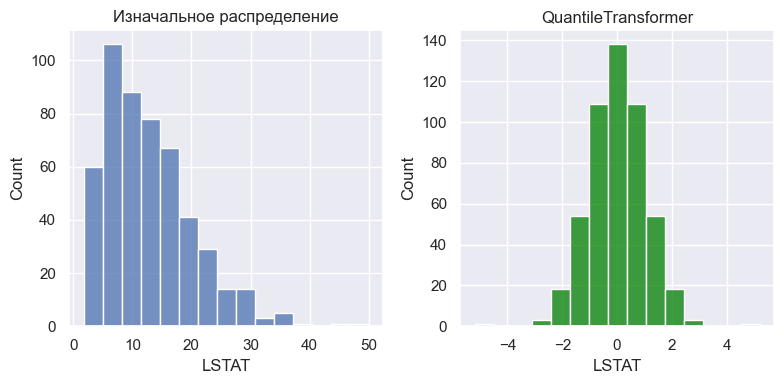

In [544]:
# выведем результат
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(x=boston_outlier.LSTAT, bins=15, ax=ax[0])
ax[0].set_title("Изначальное распределение")

sns.histplot(x=boston_qt.LSTAT, bins=15, color="green", ax=ax[1])
ax[1].set_title("QuantileTransformer")

plt.tight_layout()
plt.show()

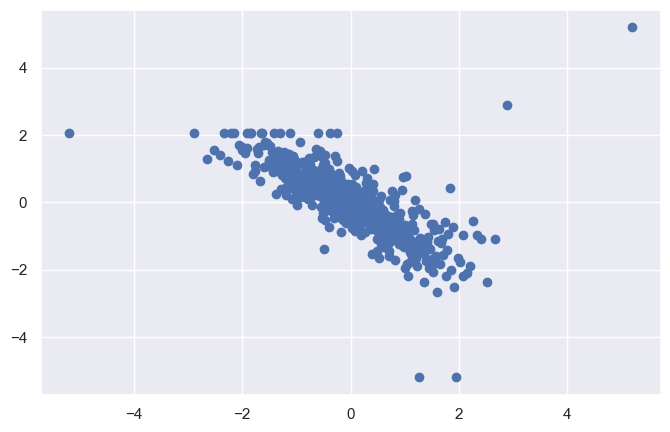

In [545]:
# посмотрим, выправилась ли взаимосвязь
plt.scatter(boston_qt.LSTAT, boston_qt.MEDV);

In [546]:
# эффект выбросов сохранился
print(max(boston_qt.LSTAT), max(boston_qt.MEDV))

5.19933758270342 5.19933758270342


In [547]:
# сравним исходную корреляцию
print(boston_outlier[["LSTAT", "MEDV"]].corr().iloc[0, 1])

-0.5772033139947359


In [548]:
# с корреляцией после преобразования
print(boston_qt.corr().iloc[0, 1])

-0.7037287662365327


## Дополнительные материалы

### Pipeline и ColumnTransformer

#### ColumnTransformer

In [549]:
# создадим датасет с данными о клиентах банка
scoring_dict: dict[str, object] = {
    "Name": ["Иван", "Николай", "Алексей", "Александра", "Евгений", "Елена"],
    "Age": [35, 43, 21, 34, 24, 27],
    "Experience": [7, 13, 2, np.nan, 4, 12],
    "Salary": [95, 135, 73, 100, 78, 110],
    "Credit_score": ["Good", "Good", "Bad", "Medium", "Medium", "Good"],
    "Outcome": [1, 1, 0, 1, 0, 1],
}

scoring = pd.DataFrame(scoring_dict)
scoring

,Name,Age,Experience,Salary,Credit_score,Outcome
0,Иван,35,7.0,95,Good,1
1,Николай,43,13.0,135,Good,1
2,Алексей,21,2.0,73,Bad,0
3,Александра,34,NaN,100,Medium,1
4,Евгений,24,4.0,78,Medium,0
5,Елена,27,12.0,110,Good,1


In [ ]:
# разобьем данные на признаки и целевую переменную
p_var = scoring.iloc[:, 1:-1]
q_var = scoring.Outcome

# поместим название количественных и категориальных признаков в списки
num_col = ["Age", "Experience", "Salary"]
cat_col = ["Credit_score"]


imputer = SimpleImputer(strategy="mean")


scaler = StandardScaler()


encoder = OrdinalEncoder(categories=[["Bad", "Medium", "Good"]])

# поместим их в отдельные пайплайны
num_transformer = make_pipeline(imputer, scaler)
cat_transformer = make_pipeline(encoder)

# поместим пайплайны в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[("num", num_transformer, num_col), ("cat", cat_transformer, cat_col)]
)


model = LogisticRegression()

# создадим еще один пайплайн, который будет включать объект ColumnTransformer и
# объект модели
pipe = make_pipeline(preprocessor, model)

pipe.fit(p_var, q_var)

# сделаем прогноз
pipe.predict(p_var)

array([1, 1, 0, 1, 0, 1])

#### Библиотека joblib

##### Сохранение пайплайна

In [551]:
# сохраним пайплайн в файл с расширением .joblib
joblib.dump(pipe, "pipe.joblib")

# импортируем из файла
new_pipe = joblib.load("pipe.joblib")

# обучим модель и сделаем прогноз
new_pipe.fit(p_var, q_var)
pipe.predict(p_var)

array([1, 1, 0, 1, 0, 1])

##### Кэширование функции

In [552]:
# напишем функцию, которая принимает список чисел
# и выдает их квадрат


def square_range(start_num: int, end_num: int) -> list[int]:
    """Return a list of squared numbers in the given range with delay."""
    res_3 = []
    # пройдемся по заданному перечню
    for i in range(start_num, end_num):
        res_3.append(i**2)
        # искусственно замедлим исполнение
        time.sleep(0.5)

    return res_3


start = time.time()
res_4 = square_range(1, 21)
end = time.time()

# посмотрим на время исполнения и финальный результат
print(end - start)
print(res_4)

10.009868383407593
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


In [553]:
# определим, куда мы хотим сохранить кэш
location = "/content/"

# используем класс Memory
memory = joblib.Memory(location, verbose=0)


def square_range_cached(start_num: int, end_num: int) -> list[int]:
    """Return a list of squared numbers in the given range (slow version)."""
    res = []
    # пройдемся по заданному перечню
    for i in range(start_num, end_num):
        res.append(i**2)
        # искусственно замедлим исполнение
        time.sleep(0.5)

    return res


# поместим в кэш
square_range_cached = memory.cache(square_range_cached)

# при первом вызове функции время исполнения не изменится
start = time.time()
res_2 = square_range_cached(1, 21)
end = time.time()

print(end - start)
print(res_2)

0.0034439563751220703
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


In [554]:
start = time.time()
res_2 = square_range_cached(1, 21)
end = time.time()

print(end - start)
print(res_2)

0.008484125137329102
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400]


##### Параллелизация

In [555]:
n_cpu = joblib.cpu_count()
n_cpu

8

In [556]:
def slow_square(r_var: int) -> int:
    """Return the square of a number with artificial delay."""
    time.sleep(1)
    return r_var**2

In [557]:
%time [slow_square(i) for i in range(10)]

CPU times: total: 0 ns
Wall time: 10 s


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [558]:
# функция delayed() разделяет исполнение кода на несколько задач (функций)
delayed_funcs = [delayed(slow_square)(i) for i in range(10)]

# класс Parallel отвечает за параллелизацию
# если указать n_jobs = -1, будут использованы все доступные CPU
parallel_pool = Parallel(n_jobs=n_cpu)

%time parallel_pool(delayed_funcs)

CPU times: total: 15.6 ms
Wall time: 2.01 s


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [559]:
# для наглядности выведем задачи, созданные функцией delayed()
delayed_funcs

[(<function __main__.slow_square(r_var: int) -> int>, (0,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (1,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (2,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (3,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (4,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (5,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (6,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (7,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (8,), {}),
 (<function __main__.slow_square(r_var: int) -> int>, (9,), {})]

### Встраивание функций и классов в sklearn

#### FunctionTransformer

In [560]:
def encoder2(df: pd.DataFrame, col_2: str, map_dict: dict[str, int]) -> pd.DataFrame:
    """Return a copy of df with the given column encoded using map_dict."""
    df_map = df.copy()
    df_map[col_2] = df_map[col_2].map(map_dict)
    return df_map

In [561]:
map_dict_2 = {"Bad": 0, "Medium": 1, "Good": 2}

In [562]:
# поместим функцию в класс FunctionTransformer и создадим объект этого класса
# передадим параметры в виде словаря
encoder = FunctionTransformer(
    func=encoder2, kw_args={"col_2": "Credit_score", "map_dict": map_dict_2}
)

In [563]:
# FunctionTransformer автоматически создаст методы
# в частности, метод .fit_transform()
encoder.fit_transform(p_var)

,Age,Experience,Salary,Credit_score
0,35,7.0,95,2
1,43,13.0,135,2
2,21,2.0,73,0
3,34,NaN,100,1
4,24,4.0,78,1
5,27,12.0,110,2
